## Lukasz Harazin: Getting historical prices 

Explores IronIA database to pick representative funds for each country selected for the algorithm. 
Then retrieves historical prices for selected funds to perform backtesting.

In [5]:
import logging
import json
import pandas as pd
import numpy as np
import random
from time import time
from matplotlib import pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

In [6]:
credentials = service_account.Credentials.from_service_account_file('harazinlt.json')
client = bigquery.Client(credentials=credentials)

### Exploring all available funds

In [23]:
sql = """SELECT isin,allfunds_id,short_name,manager_name,
            class_code,geo_zone,inception_at,modified_date,
            management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
        FROM Ironia_Ext.instruments 
        WHERE available_ironia=True AND asset_type='RVG' AND currency='EUR' AND currency_hedge=False AND nomin=False AND income=False
        """
all_funds_RVG_EUR = client.query(sql).to_dataframe()
all_funds_RVG_EUR.index = all_funds_RVG_EUR['isin']
all_funds_RVG_EUR.to_csv('Data/all_funds_RVG_EUR.csv')
all_funds_RVG_EUR.head()

,isin,allfunds_id,short_name,manager_name,class_code,geo_zone,inception_at,modified_date,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
isin,,,,,,,,,,,,,
LU1893657210,LU1893657210,0164347,"THEAM QUANT EQUITY WO ""P"" (EUR) A",THEAM,P,EU,2019-11-08,2023-06-30,0.700,1.02,NaN,3.0,NaN
FR0013294725,FR0013294725,0054670,"CPR SILVER AGE ""R"" (EUR)",CPR AM,R,EU,2017-11-15,2023-06-30,0.794,1.01,15.0,3.0,NaN
LU0792910308,LU0792910308,0154642,"ROBECO EM MKT EQ ""F"" (EUR)",ROBECO,F,GEM,2012-07-04,2023-06-30,0.800,1.06,0.0,0.0,0.0000
LU0128640439,LU0128640439,0421003,"ROBECO EMERGING MARKETS EQUITIES ""M""",ROBECO,M,GEM,2001-09-03,2023-06-30,2.000,2.26,0.0,5.0,0.9900
LU0187076913,LU0187076913,0421046,"ROBECO EMERGING MARKETS EQUITIES ""D""",ROBECO,D,GEM,1994-09-29,2023-06-30,1.500,1.76,0.0,5.0,0.6188


In [8]:
# Filtering funds by geo_zone
all_funds_RVG_EUR.loc[(all_funds_RVG_EUR['geo_zone'] == 'IN') & (all_funds_RVG_EUR['ongoing_charges'] < 2) & (all_funds_RVG_EUR['inception_at'] < '2012-07-01')]

,isin,allfunds_id,short_name,manager_name,class_code,geo_zone,inception_at,modified_date,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
isin,,,,,,,,,,,,,
LU0491217419,LU0491217419,0094767,"ROBECO INDIAN EQUITIES ""D"" (EUR)",ROBECO,D,IN,2010-08-23,2023-06-30,1.60,1.91,0.0,5.00,0.6600
LU0255978933,LU0255978933,0014684,"PICTET INDIAN EQUITIES ""I"" (EUR) ACC",PICTET FUNDS,I,IN,2006-06-15,2023-06-30,0.70,1.02,0.0,5.00,0.0000
LU0255979071,LU0255979071,0014721,"PICTET INDIAN EQUITIES ""P"" (EUR) ACC",PICTET FUNDS,P,IN,2006-06-15,2023-06-30,1.40,1.73,0.0,5.00,0.5775
LU0625739619,LU0625739619,0154657,"PICTET INDIA INDEX ""P"" (EUR)",PICTET FUNDS,P,IN,2011-07-12,2021-07-06,0.50,0.74,0.0,5.00,0.0000
LU0625739700,LU0625739700,0127398,"PICTET INDIA INDEX ""R"" (EUR)",PICTET FUNDS,R,IN,2011-07-12,2021-07-06,0.75,0.99,0.0,5.00,0.3094
LU0252216055,LU0252216055,0002157,"AB INDIA GRWT PRTF ""I"" (EUR)",ALLIANCE BERNSTEIN,I,IN,2000-11-23,2023-06-30,0.95,1.35,0.0,1.50,NaN
LU0252216485,LU0252216485,0002155,"AB INDIA GROWTH PORTFOLIO ""AX"" AC",ALLIANCE BERNSTEIN,AX,IN,2000-11-23,2023-06-30,1.53,1.95,0.0,5.00,0.2784
LU0288299570,LU0288299570,0027013,"BGF INDIA ""D2"" (EUR)",BLACKROCK GLOBAL FUNDS,D2,IN,2007-02-27,2023-06-30,0.75,1.09,NaN,5.00,0.0000
LU0248271941,LU0248271941,0006536,"BGF INDIA ""A2"" (EUR)",BLACKROCK GLOBAL FUNDS,A2,IN,2005-02-02,2023-06-30,1.50,1.84,NaN,5.00,0.8044


### Exploring various ratios

In [9]:
sql = """SELECT distinct ratio
        FROM Ironia_Ext.Ratios 
        WHERE allfunds_id = 0018110 AND date = '2023-08-16'
        ORDER BY ratio"""
ratios = client.query(sql).to_dataframe()
ratios

,ratio
0,alpha
1,bear_beta
2,beta
3,bull_beta
4,calmar
5,correlation
6,downside_deviation
7,information_ratio
8,linear_return
9,log_annualized_return


In [10]:
sql = """SELECT distinct benchmark_name
        FROM Ironia_Ext.Ratios AS R
                INNER JOIN Ironia_Ext.instruments AS I ON R.allfunds_id = CAST(I.allfunds_id AS INT)
        WHERE R.ratio = 'tracking_error' AND R.period = '5y' AND R.date = '2023-09-20' AND R.value_product < 0.09 AND
                available_ironia=True AND currency='EUR' AND currency_hedge=False AND nomin=False AND income=False
                AND management_fee < 1
        """
ratios = client.query(sql).to_dataframe()
ratios

,benchmark_name
0,MSCI AC Asia ex Japan Net Total Return USD Index
1,MSCI AC ASEAN USD Net
2,Bloomberg Barclays Pan-European High Yield Tot...
3,Bloomberg Commodity Index Total Return
4,EQUILIBRADO
...,...
69,MODERADO
70,MSCI Emerging Markets Net Total Return USD Index
71,MSCI Europe ex UK Net Return EUR Index
72,AGRESIVO


In [24]:
sql = """SELECT R.allfunds_id, R.value_product,
            isin,short_name,manager_name,benchmark_name
            class_code,geo_zone,inception_at,
            management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
        FROM Ironia_Ext.Ratios AS R
                INNER JOIN Ironia_Ext.instruments AS I ON R.allfunds_id = CAST(I.allfunds_id AS INT)
        WHERE R.ratio = 'tracking_error' AND R.period = '5y' AND R.date = '2023-09-20' AND R.value_product < 0.09 AND
                available_ironia=True AND currency='EUR' AND currency_hedge=False AND nomin=False AND income=False
                AND management_fee < 1 AND benchmark_name = 'CAC 40 Net Total Return Index'
        """
low_tracking_error = client.query(sql).to_dataframe()
low_tracking_error

,allfunds_id,value_product,isin,short_name,manager_name,class_code,geo_zone,inception_at,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
0,294040,0.08293,FR0012806578,"ODDO BHF AVENIR ""CN"" (EUR) ACC",ODDO ASSET MANAGEMENT,CAC 40 Net Total Return Index,FR,2015-12-02,0.9,0.35,20.0,4.0,0.0


In [25]:
low_tracking_error.to_csv('Data/funds_with_low_tracking_error.csv')

### Selected funds - optimized for fees and index tracking

In [13]:
country_to_isin = dict()
country_to_isin.update({'United States': 'IE0032126645'}) # 59.3% weight in ACWI Index
country_to_isin.update({'Eurozone': 'IE0008248803'}) # 9.4% weight in ACWI Index
country_to_isin.update({'Japan': 'IE0007286036'}) # 6.1% weight in ACWI Index
country_to_isin.update({'United Kingdom': 'LU0679964535'})# 3.9% weight in ACWI Index
country_to_isin.update({'China': 'LU0625737910'}) # 3.3% weight in ACWI Index
country_to_isin.update({'India': 'LU0248271941'}) # 1.6% weight in ACWI Index
country_to_isin.update({'Korea': 'LU0301637293'}) # 1.4% weight in ACWI Index
country_to_isin.update({'Brazil': 'LU0616857586'}) # 0.6% weight in ACWI Index
country_to_isin.update({'ACWI': 'IE00B62WCL09'}) # benchmark ACWI Index

selected_funds = all_funds_RVG_EUR.loc[country_to_isin.values()]
selected_funds

,isin,allfunds_id,short_name,manager_name,class_code,geo_zone,inception_at,modified_date,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
isin,,,,,,,,,,,,,
IE0032126645,IE0032126645,0018110,VANGUARD U.S. 500 STOCK INDEX (EUR) ACC,VANGUARD INVESTMENT SERIES PLC,I,US,2002-09-26,2023-06-30,0.10,0.10,NaN,0.0,0.0000
IE0008248803,IE0008248803,0243703,VANGUARD EUROZONE STOCK INDEX (EUR) ACC,VANGUARD INVESTMENT SERIES PLC,I,EUR,2001-10-25,2023-06-30,0.12,0.12,NaN,0.0,0.0000
IE0007286036,IE0007286036,0067444,VANGUARD JAPAN STOCK INDEX (EUR) ACC,VANGUARD INVESTMENT SERIES PLC,A,JP,2006-03-29,2023-06-30,0.16,0.16,NaN,0.0,0.0000
LU0679964535,LU0679964535,0157422,"BGF UNITED KINGDOM ""D2"" (EUR)",BLACKROCK GLOBAL FUNDS,D2,UK,2011-09-20,2023-06-30,0.75,1.07,NaN,5.0,0.0000
LU0625737910,LU0625737910,0155041,"PICTET CHINA INDEX ""P"" (EUR)",PICTET FUNDS,P,CHI,2011-07-12,2023-06-30,0.50,0.70,0.0,5.0,0.0000
LU0248271941,LU0248271941,0006536,"BGF INDIA ""A2"" (EUR)",BLACKROCK GLOBAL FUNDS,A2,IN,2005-02-02,2023-06-30,1.50,1.84,NaN,5.0,0.8044
LU0301637293,LU0301637293,0072985,"JPM KOREA EQUITY ""A"" (EUR) ACC",JPMORGAN AM,A,KR,2007-09-28,2023-06-30,1.50,1.82,NaN,5.0,0.7425
LU0616857586,LU0616857586,0160456,"DWS INVEST BRAZILIAN EQ ""FC"" (EUR) ACC",DWS INVESTMENTS SA,FC,BR,2012-10-24,2023-06-30,0.85,0.89,NaN,0.0,0.0000
IE00B62WCL09,IE00B62WCL09,0088006,"ISHARES DEV WRD INDX (IE) ""I"" (EUR) ACC",BLACKROCK INDEX SELECTION FUND,I,GLB,2010-05-19,2023-06-30,0.15,0.16,NaN,0.0,0.0000


### Retrieving historical prices since 2013

In [14]:
sql = """SELECT date, nav 
        FROM Ironia_Ext.Navs 
        WHERE allfunds_id = 0088006
        ORDER BY date"""
prices = client.query(sql).to_dataframe()
prices

,date,nav
0,2011-01-26,10.340000
1,2011-02-03,10.499000
2,2011-02-15,10.695895
3,2011-02-16,10.754890
4,2011-02-17,10.767325
...,...,...
3008,2023-08-16,36.411228
3009,2023-08-17,36.178465
3010,2023-08-18,36.177785
3011,2023-08-21,36.292887


In [15]:
df_prices = pd.DataFrame(index=pd.date_range('2013-01-02', '2023-08-23', freq='B'))
for isin in selected_funds.index:
    allfunds_id = selected_funds.loc[isin].loc['allfunds_id']

    sql = f"""SELECT * 
            FROM Ironia_Ext.Navs 
            WHERE allfunds_id = {allfunds_id}
            ORDER BY date"""
    prices = client.query(sql).to_dataframe()
    prices.index = pd.DatetimeIndex(prices['date'])
    prices = prices[~prices.index.duplicated(keep='first')]
    df_prices[isin] = prices['nav']

df_prices

,IE0032126645,IE0008248803,IE0007286036,LU0679964535,LU0625737910,LU0248271941,LU0301637293,LU0616857586,IE00B62WCL09
2013-01-02,11.5218,121.2740,103.2641,87.03,77.29,16.86,8.14,104.49,11.593814
2013-01-03,11.6241,121.0621,104.7968,87.15,79.45,17.06,8.20,105.44,11.695514
2013-01-04,11.7256,121.3894,107.3677,87.51,81.05,16.95,8.17,105.96,11.789624
2013-01-07,11.6408,120.7851,106.3010,87.42,81.20,16.87,8.19,105.82,11.713590
2013-01-08,11.6350,120.5640,106.1076,87.18,80.82,16.91,8.12,104.73,11.704624
...,...,...,...,...,...,...,...,...,...
2023-08-17,47.7749,263.7527,233.0415,155.14,107.28,44.00,12.86,176.37,36.178465
2023-08-18,47.8402,262.6807,233.1748,153.08,104.89,44.00,12.84,175.44,36.177785
2023-08-21,48.1075,263.2737,231.4313,153.84,102.87,44.15,12.79,174.38,36.292887
2023-08-22,48.1377,265.2265,235.6071,154.12,104.25,44.50,12.97,177.45,36.399962


In [17]:
df_prices = df_prices.ffill()
df_prices.to_csv('Data/Funds_Prices_2013-2023.csv')
df_prices

,IE0032126645,IE0008248803,IE0007286036,LU0679964535,LU0625737910,LU0248271941,LU0301637293,LU0616857586,IE00B62WCL09
2013-01-02,11.5218,121.2740,103.2641,87.03,77.29,16.86,8.14,104.49,11.593814
2013-01-03,11.6241,121.0621,104.7968,87.15,79.45,17.06,8.20,105.44,11.695514
2013-01-04,11.7256,121.3894,107.3677,87.51,81.05,16.95,8.17,105.96,11.789624
2013-01-07,11.6408,120.7851,106.3010,87.42,81.20,16.87,8.19,105.82,11.713590
2013-01-08,11.6350,120.5640,106.1076,87.18,80.82,16.91,8.12,104.73,11.704624
...,...,...,...,...,...,...,...,...,...
2023-08-17,47.7749,263.7527,233.0415,155.14,107.28,44.00,12.86,176.37,36.178465
2023-08-18,47.8402,262.6807,233.1748,153.08,104.89,44.00,12.84,175.44,36.177785
2023-08-21,48.1075,263.2737,231.4313,153.84,102.87,44.15,12.79,174.38,36.292887
2023-08-22,48.1377,265.2265,235.6071,154.12,104.25,44.50,12.97,177.45,36.399962


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a Dat

<Axes: >

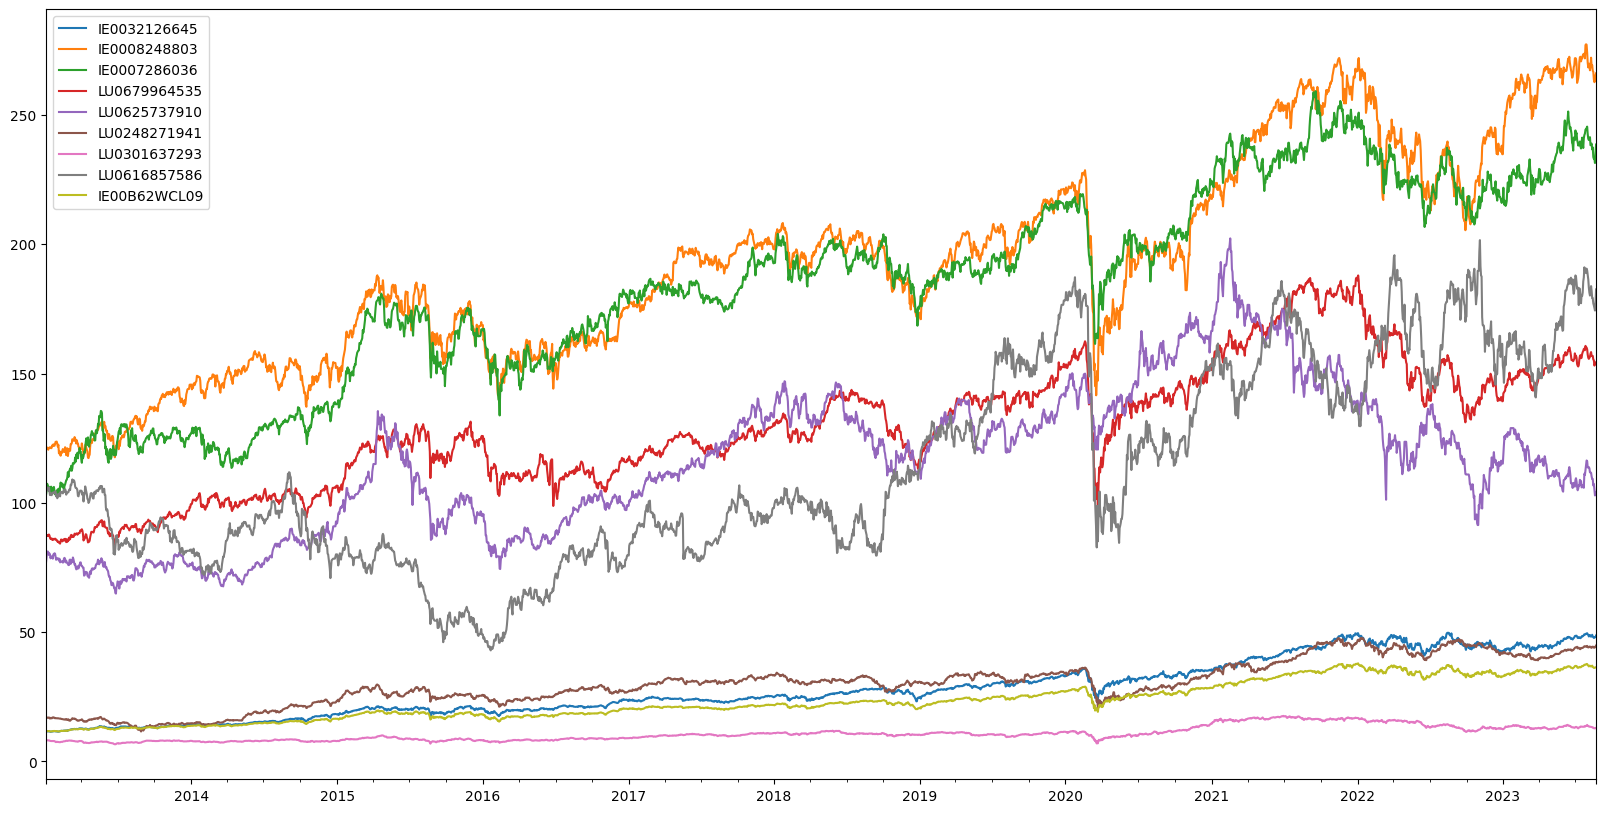

In [18]:
df_prices.plot(figsize=(20,10))

### Exploring returns and sharpe ratios

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a Dat

<Axes: >

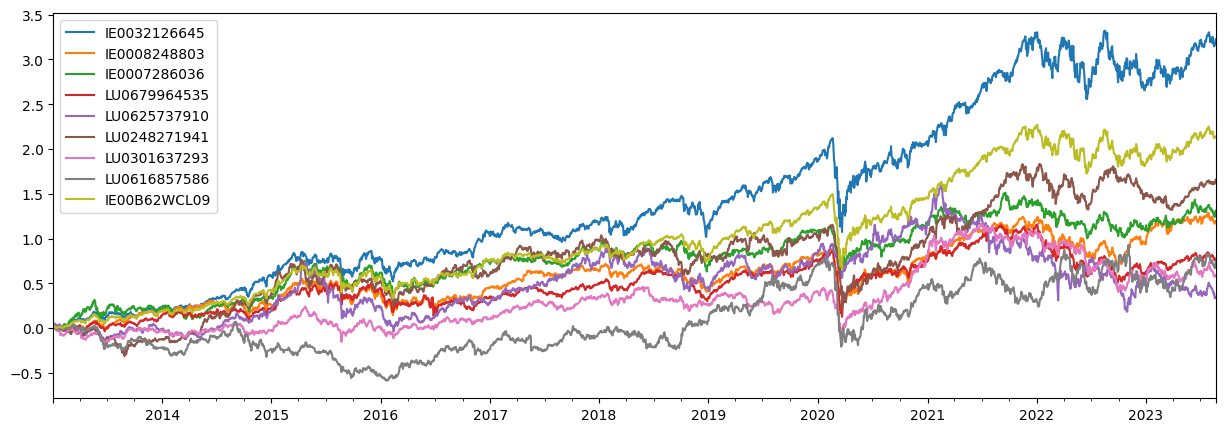

In [19]:
daily_returns = df_prices.pct_change()
cum_returns = ((daily_returns + 1).cumprod() - 1)
cum_returns.plot(figsize=(15, 5))

In [20]:
def daily_to_annual_returns(daily_returns):
    daily_returns.iloc[0] = 0
    tot_ret = (daily_returns + 1).prod() - 1

    #sim_tot_ret = (df_prices.iloc[-1]/df_prices.iloc[0])-1 # Alternativa
    
    init_date = daily_returns.index[0]
    end_date = daily_returns.index[-1]
    fyears = (end_date - init_date) / pd.Timedelta(days=365, hours=6) # Calculamos el nº de años que contiene la serie que hemos pasado
    #print('Years:',fyears)
    
    anual_ret = np.power(tot_ret + 1, 1/fyears) - 1  # lo anualizamos (raíz enésima: 1 partido el cálculo que se muestra)
    return anual_ret

In [21]:
def get_annual_summary(df_prices):
    daily_returns = df_prices.pct_change()
    annual_returns = daily_to_annual_returns(daily_returns)
    annual_volatility = daily_returns.std()*np.sqrt(252)

    annual_summary = pd.DataFrame()
    annual_summary['Return'] = annual_returns
    annual_summary['Volatility'] = annual_volatility
    annual_summary['Sharpe'] = annual_returns/annual_volatility
    return annual_summary

In [22]:
get_annual_summary(df_prices)

,Return,Volatility,Sharpe
IE0032126645,0.145102,0.183746,0.789690
IE0008248803,0.076681,0.178332,0.429992
IE0007286036,0.081910,0.179361,0.456677
LU0679964535,0.055377,0.174951,0.316531
LU0625737910,0.028439,0.233885,0.121592
LU0248271941,0.096254,0.206130,0.466958
LU0301637293,0.044086,0.199732,0.220728
LU0616857586,0.053860,0.335489,0.160541
IE00B62WCL09,0.113561,0.151084,0.751638
